In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [2]:
# One Hot econding para pasar a numéricas todas las categóricas
df_jo_cp = pd.get_dummies(df_jo_cp, columns=['transfer_type'], drop_first=True, dtype=int)
df_jo_cp = pd.get_dummies(df_jo_cp, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [3]:
# SEGMENTACIONES EN DATAFRAMES USUARIOS REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)

repeat_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 1) | (df_jo_cp['n_backs'] > 1) | (df_jo_cp['n_recovery'] > 1) | (df_jo_cp['n_inc_back'] > 1)| (df_jo_cp['n_inc_fees'] > 1)]

# Sort and group by user_id, keeping repetitive activities
repeat_users_df = repeat_users_df.sort_values('created_at').reset_index(drop=True)

# Obtener los usuarios nuevos (aquellos con solo una acción)

new_users_df = df_jo_cp[(df_jo_cp['n_fees'] <= 1) & (df_jo_cp['n_backs'] <= 1) & (df_jo_cp['n_recovery'] <= 1) & (df_jo_cp['n_inc_back'] <= 1) & (df_jo_cp['n_inc_fees'] <= 1)]


new_users_df = new_users_df.sort_values('created_at').groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')

Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 11938
Número de filas en el DataFrame de usuarios repetitivos: 18808


In [4]:
# VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 42.08 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 57.83 %


In [5]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type_regular','n_recovery', 'n_fees', 'n_backs','n_inc_back','n_inc_fees','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment_before','n_cr_fe_w','category_nice','category_rejected_direct_debit','needs_m_check_recov']
# Rellenar NaN con 0
df_jo_cp [columnas_deseadas] = df_jo_cp[columnas_deseadas].fillna(0)

In [6]:
df_jo_cp[columnas_deseadas]

,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit,needs_m_check_recov
0,13,1,1,0,0,0,1,0,1.16935,6347.577148,1.3,3.9,1.0,0,0.0,0,0,1
1,14,0,1,0,0,1,0,0,1.18803,5630.115723,1.3,4.0,100.0,0,1.0,0,0,0
2,19,1,1,0,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
3,19,1,1,1,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
4,19,1,1,0,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,23,6,0,0,2,2,1,0,0.00000,10627.522461,0.7,5.3,50.0,0,1.0,1,0,0
32088,23,6,0,0,3,3,0,0,0.00000,10627.522461,0.7,5.3,100.0,0,1.0,1,0,0
32089,23,6,0,3,2,2,4,4,0.00000,10627.522461,0.7,5.3,50.0,0,0.0,0,0,1
32090,23,6,0,0,1,1,0,0,0.00000,10627.522461,0.7,5.3,60.0,0,1.0,1,0,0


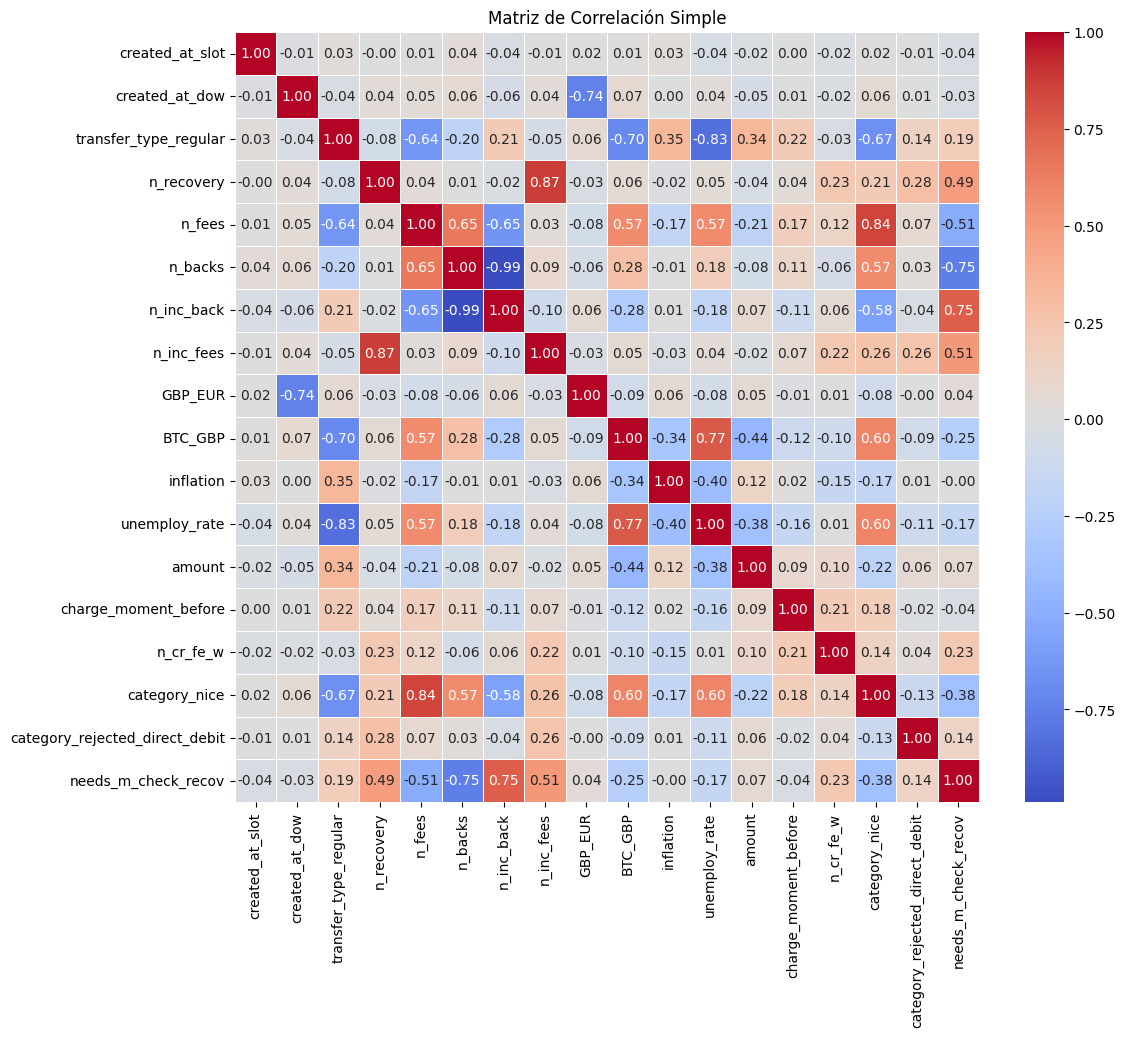

In [7]:
# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = new_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [8]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 14)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)

needs_m_check_recov
0    5024
1    5024
Name: count, dtype: int64


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [9]:
# Rellenar NaN con 0
df_simpl = df_simpl.fillna(0)

In [10]:
# Visualización datos antes del escalador
display(df_simpl.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = df_simpl['needs_m_check_recov']
df_simpl = df_simpl.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df_simpl)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=df_simpl.columns, index=df_simpl.index)

# Visualización datos después del escalador
display(X.head(10))

,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit,needs_m_check_recov
0,15,0,1,0,0,0,1,0,1.14888,5530.940918,0.8,4.2,100.0,0,0.0,0,0,1
1,20,4,1,0,0,0,1,0,1.20451,5452.721191,1.3,4.0,100.0,0,0.0,0,0,1
2,13,1,1,0,0,0,1,0,1.16935,6347.577148,1.3,3.9,1.0,0,0.0,0,0,1
3,9,1,1,0,0,1,0,0,1.19156,5060.597168,1.3,4.0,100.0,0,1.0,0,0,0
4,11,5,1,0,0,1,0,0,0.00000,5529.749023,1.3,4.0,100.0,0,1.0,0,0,0
5,6,2,1,0,0,1,0,0,1.12500,5335.962891,0.8,4.2,50.0,0,1.0,0,0,0
6,6,4,1,0,0,1,0,0,1.17000,5551.017090,1.3,4.0,30.0,0,1.0,0,0,0
7,9,1,1,0,0,1,0,0,1.14746,6278.592773,0.8,4.2,100.0,0,1.0,0,0,0
8,22,6,1,0,0,1,0,0,0.00000,6581.921875,1.8,4.1,100.0,0,1.0,0,0,0
9,8,5,1,0,0,1,0,0,0.00000,6152.196289,1.8,4.1,100.0,0,1.0,0,0,0


,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit
0,0.468988,-1.493342,1.223079,-0.413619,-1.006555,-1.543952,1.559942,-0.436017,0.597161,-2.408279,0.414722,-1.829371,0.694919,-0.209297,-1.314126,-1.133291,-0.116922
1,1.440055,0.691068,1.223079,-0.413619,-1.006555,-1.543952,1.559942,-0.436017,0.721371,-2.471517,2.335778,-2.344163,0.694919,-0.209297,-1.314126,-1.133291,-0.116922
2,0.080562,-0.947240,1.223079,-0.413619,-1.006555,-1.543952,1.559942,-0.436017,0.642866,-1.748061,2.335778,-2.601559,-2.800397,-0.209297,-1.314126,-1.133291,-0.116922
3,-0.696292,-0.947240,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,0.692456,-2.788534,2.335778,-2.344163,0.694919,-0.209297,0.207507,-1.133291,-0.116922
4,-0.307865,1.237171,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,-1.968032,-2.409243,2.335778,-2.344163,0.694919,-0.209297,0.207507,-1.133291,-0.116922
5,-1.278932,-0.401137,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,0.543843,-2.565911,0.414722,-1.829371,-1.070392,-0.209297,0.207507,-1.133291,-0.116922
6,-1.278932,0.691068,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,0.644317,-2.392048,2.335778,-2.344163,-1.776517,-0.209297,0.207507,-1.133291,-0.116922
7,-0.696292,-0.947240,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,0.593991,-1.803832,0.414722,-1.829371,0.694919,-0.209297,0.207507,-1.133291,-0.116922
8,1.828482,1.783273,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,-1.968032,-1.558602,4.256835,-2.086767,0.694919,-0.209297,0.207507,-1.133291,-0.116922
9,-0.890505,1.237171,1.223079,-0.413619,-1.006555,0.647689,-0.641049,-0.436017,-1.968032,-1.906018,4.256835,-2.086767,0.694919,-0.209297,0.207507,-1.133291,-0.116922


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_inc_fees: 5.77395821
n_inc_back: 4.03442866
n_recovery: 3.82902884
n_backs: -3.74207357
n_fees: -1.01291197
n_cr_fe_w: -0.66970551
unemploy_rate: 0.63175003
charge_moment_before: 0.51712805
category_rejected_direct_debit: 0.34853674
inflation: -0.31568474
category_nice: 0.20596575
transfer_type_regular: -0.18839553
created_at_dow: 0.14464489
GBP_EUR: 0.04327441
created_at_slot: -0.01136889
amount: 0.00310293
BTC_GBP: -0.00035889

Multiplicadores de odds (elevando exp a los coeficientes):
n_inc_fees: 321.80900289
n_inc_back: 56.51062449
n_recovery: 46.01782605
n_backs: 0.02370490
n_fees: 0.36315993
n_cr_fe_w: 0.51185929
unemploy_rate: 1.88089933
charge_moment_before: 1.67720389
category_rejected_direct_debit: 1.41699260
inflation: 0.72928933
category_nice: 1.22871112
transfer_type_regular: 0.82828703
created_at_dow: 1.15562912
GBP_EUR: 1.04422440
created_at_slot: 0.98869550
amount: 1.00310775
BTC_GBP: 0.99964117


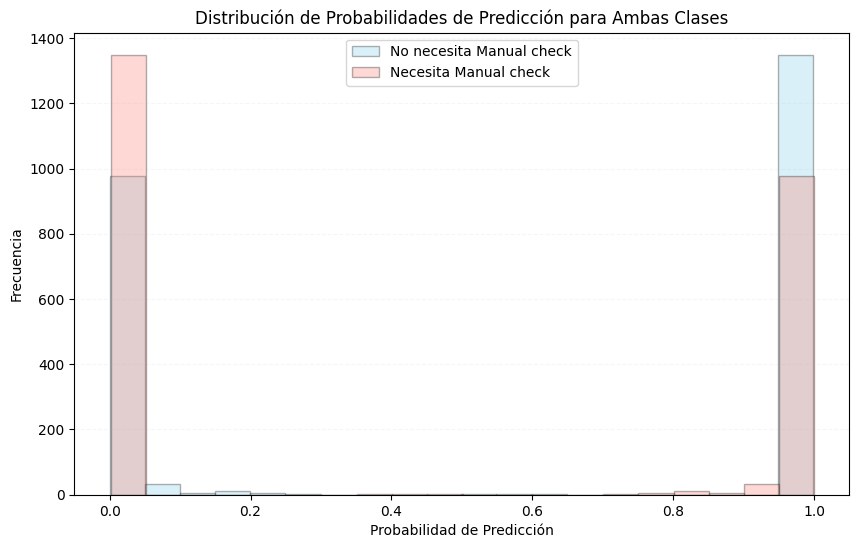

Accuracy: 0.9991624790619765
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388



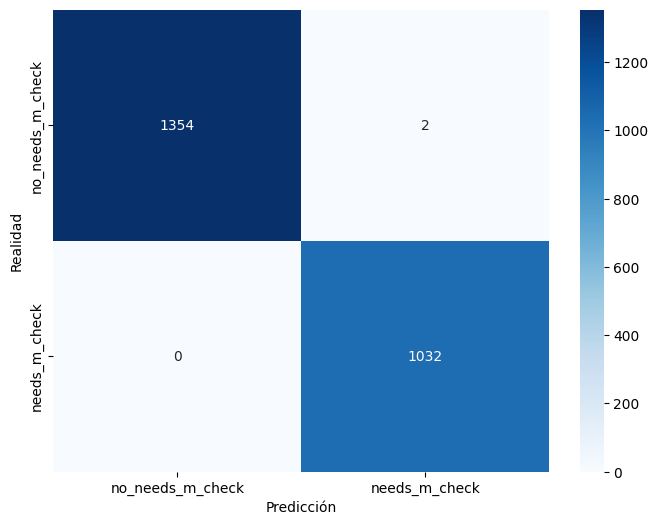

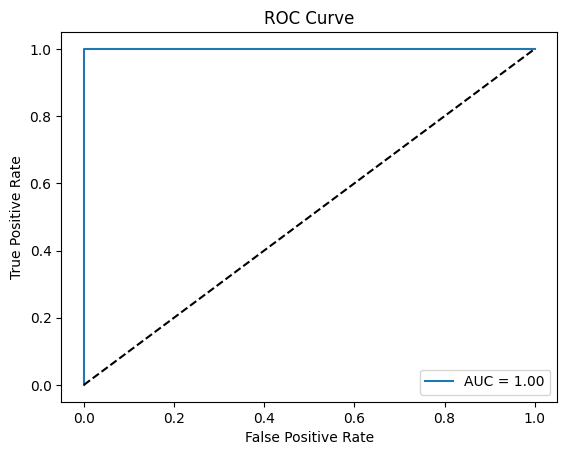

In [11]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con todas las caracteristicas para poder ver después la diferencia al aplicar Ridge y Lasso
X=df_simpl

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nMultiplicadores de odds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [12]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.9991624790619765
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388



Text(70.5815972222222, 0.5, 'Realidad')

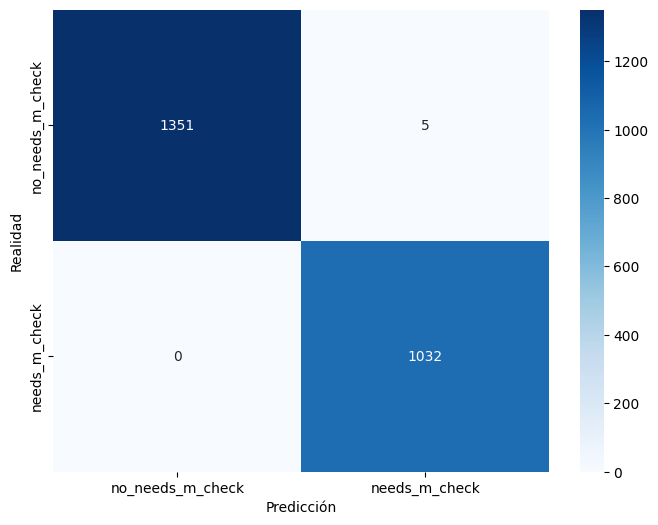

In [13]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [14]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica al modelo base 

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=42, max_iter=2000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=10, random_state=42, max_iter=2000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.9991624790619765
Exactitud L2 (Ridge): 0.9991624790619765


In [15]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l1 = list(zip(feature_names, coefs))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("\nCaracterísticas importantes para LASSO ordenadas por magnitud:")
print(importancia_no_nula)


Características importantes para LASSO ordenadas por magnitud:
           Característica  Coeficiente
6              n_inc_back    18.312780
7              n_inc_fees    17.105005
3              n_recovery    11.154778
4                  n_fees    -4.520785
2   transfer_type_regular    -4.238981
13   charge_moment_before    -1.858291
5                 n_backs    -1.764301
14              n_cr_fe_w    -1.372960
10              inflation    -0.774215
1          created_at_dow    -0.386877
0         created_at_slot    -0.152466
11          unemploy_rate    -0.070809
12                 amount     0.006947
8                 GBP_EUR    -0.004117
9                 BTC_GBP     0.000049


In [16]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l2 = list(zip(feature_names, coefs2))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
7                       n_inc_fees     5.913865
6                       n_inc_back     4.111165
3                       n_recovery     3.915129
5                          n_backs    -3.809307
4                           n_fees    -1.027401
14                       n_cr_fe_w    -0.665228
11                   unemploy_rate     0.646940
13            charge_moment_before     0.531220
16  category_rejected_direct_debit     0.357089
10                       inflation    -0.324772
15                   category_nice     0.223859
2            transfer_type_regular    -0.197633
1                   created_at_dow     0.160414
8                          GBP_EUR     0.039812
0                  created_at_slot    -0.011844
12                          amount     0.001554
9                          BTC_GBP    -0.000358


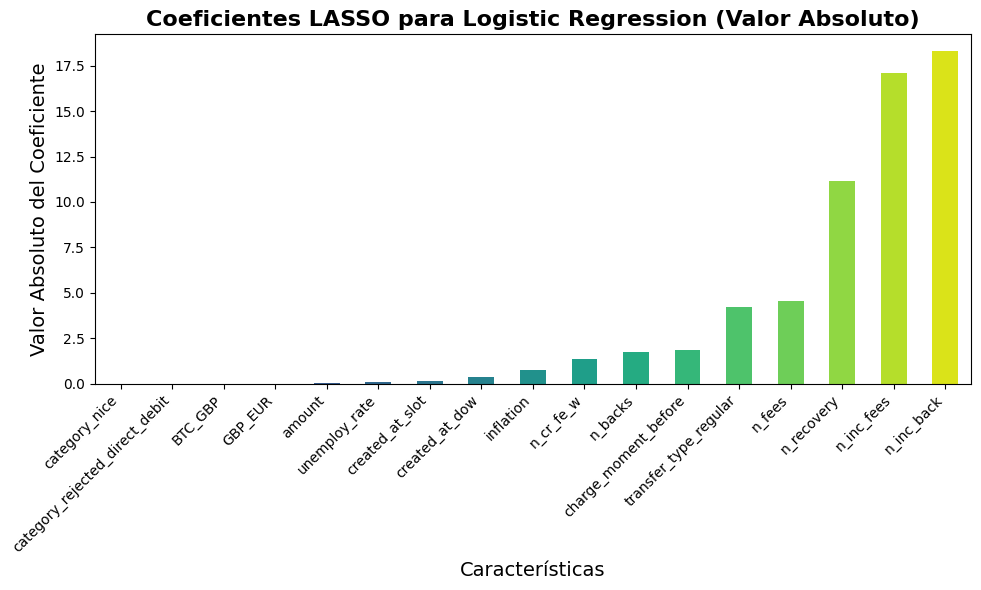

In [17]:
# Graficamos los coeficientes ordenados por valor absoluto LASSO
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l1 = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l1 = coefs_series_l1.abs().sort_values(ascending=True)

# graficar
coefs_series_l1.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l1)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

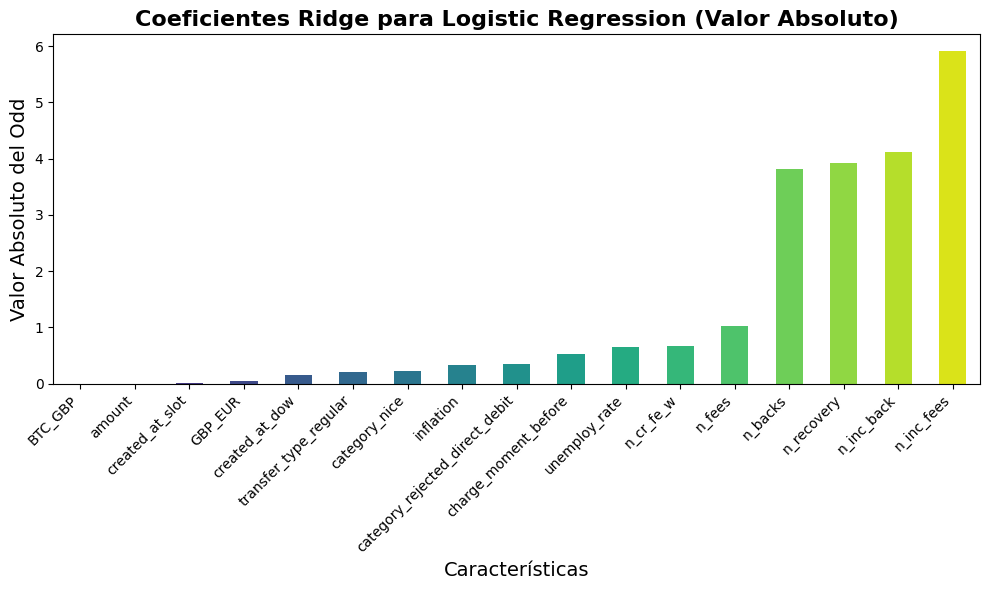

In [18]:
# Graficamos los coeficientes ordenados por valor absoluto RIDGE
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l2 = coefs_series_l2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series_l2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l2)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Odd', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [19]:
#Cálculo C optima de manera manual. LO DEJO COMENTADO PORQUE TARDA 11MINUTOS EN PROCESARSE

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)
scores_l1 = []
scores_l2 = []

# Iterar manualmente para penalización L1
for C in C_values:
    model_l1 = LogisticRegression(
        C=C, penalty='l1', solver='liblinear', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l1.append(score)

# Iterar manualmente para penalización L2
for C in C_values:
    model_l2 = LogisticRegression(
        C=C, penalty='l2', solver='liblinear', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l2, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l2.append(score)

# Encontrar el mejor C
optimal_C_l1 = C_values[np.argmax(scores_l1)]
optimal_C_l2 = C_values[np.argmax(scores_l2)]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 166.81005372000558
Mejor valor de C para penalización L2: 2.782559402207126


In [20]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones. Ahora con el LogisticRegressionCV que tiene Validación Cruzada incorporada.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='liblinear', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='liblinear', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 10000.0
Mejor valor de C para penalización L2: 2.782559402207126


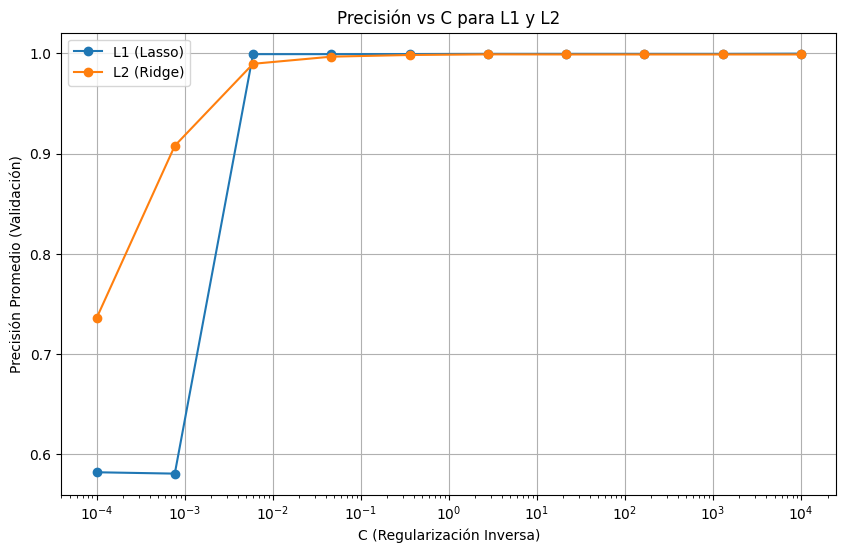

In [21]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"\nÍndice óptimo para L1: {optimal_index_l1} \nMejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"\nÍndice óptimo para L2: {optimal_index_l2} \nMejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.58209424 0.58073298 0.99926702 0.99926702 0.99937173 0.99958115
 0.99958115 0.99958115 0.99958115 0.99979058]
Puntajes promedio para L2: [0.73570681 0.9078534  0.98963351 0.99675393 0.99842932 0.99905759
 0.99895288 0.99895288 0.99895288 0.99895288]

Índice óptimo para L1: 9 
Mejor C: 10000.0

Índice óptimo para L2: 5 
Mejor C: 2.782559402207126


In [30]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='liblinear', C=optimal_C_l1, random_state=42, max_iter=2000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='liblinear', C=optimal_C_l2, random_state=42, max_iter=2000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(2.782559402207126), max_iter=2000,
                   random_state=42, solver='liblinear')

In [31]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.9991624790619765
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388

Evaluación del modelo Ridge (L2):
Precisión: 0.9991624790619765
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_inc_fees: 5.87322407
n_inc_back: 4.08828729
n_recovery: 3.88935705
n_backs: -3.78916183
n_fees: -1.02395610
n_cr_fe_w: -0.66550343
unemploy_rate: 0.64300495
charge_moment_before: 0.52696122
category_rejected_direct_debit: 0.35473063
inflation: -0.32257871
category_nice: 0.21865574
transfer_type_regular: -0.19493418
created_at_dow: 0.15589505
GBP_EUR: 0.04092901
created_at_slot: -0.01172145
amount: 0.00156968
BTC_GBP: -0.00035423

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
n_inc_back: 18.04547566
n_recovery: 14.96402087
n_inc_fees: 14.91906204
transfer_type_regular: -3.43540209
n_fees: -3.31055319
n_backs: -2.51534681
charge_moment_before: -1.52944691
n_cr_fe_w: -1.37467486
inflation: -1.22892169
GBP_EUR: 0.40121997
unemploy_rate: -0.13599435
created_at_dow: -0.13563180
category_nice: 0.10096515
created_at_slot: -0.04002340
amount: -0.00190264
BTC_GBP: 0.00000131
category_rejected_direct_debit: 0.00000000


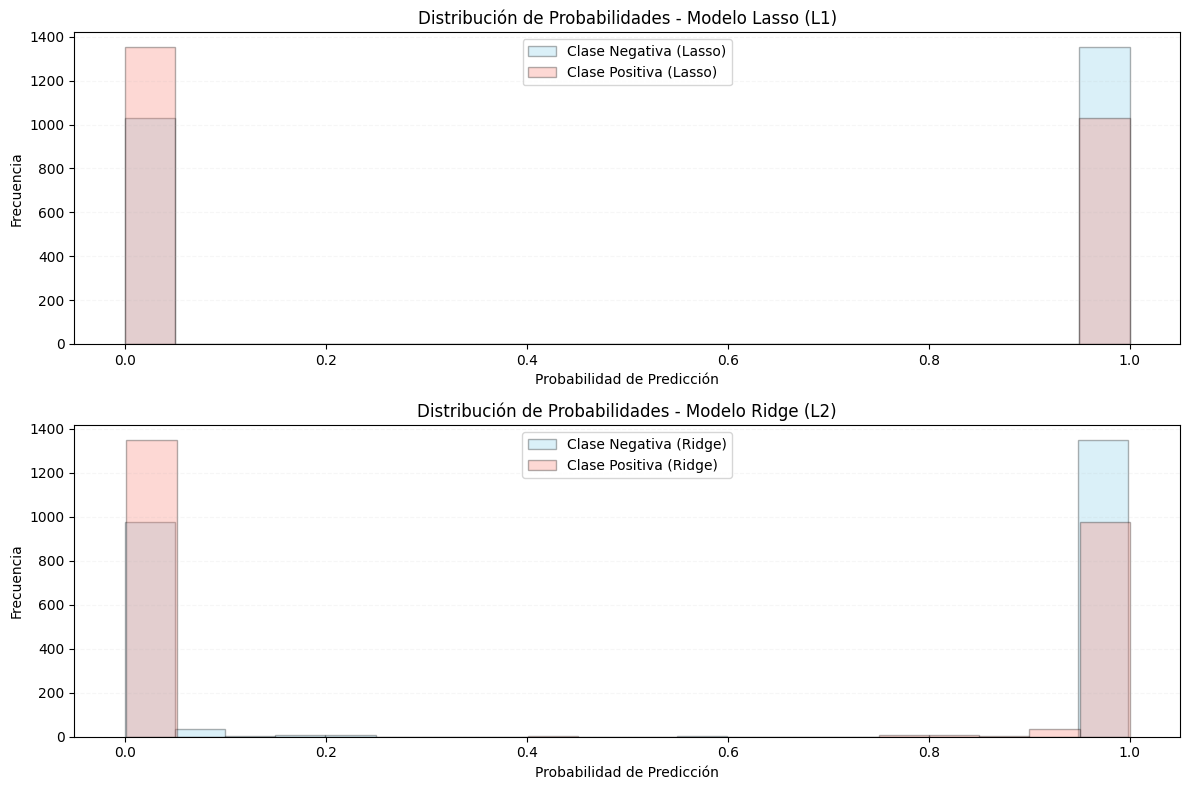

Desempeño del Modelo Lasso (L1):
Accuracy: 0.9991624790619765
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388


Desempeño del Modelo Ridge (L2):
Accuracy: 0.9991624790619765
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1356
           1       1.00      1.00      1.00      1032

    accuracy                           1.00      2388
   macro avg       1.00      1.00      1.00      2388
weighted avg       1.00      1.00      1.00      2388



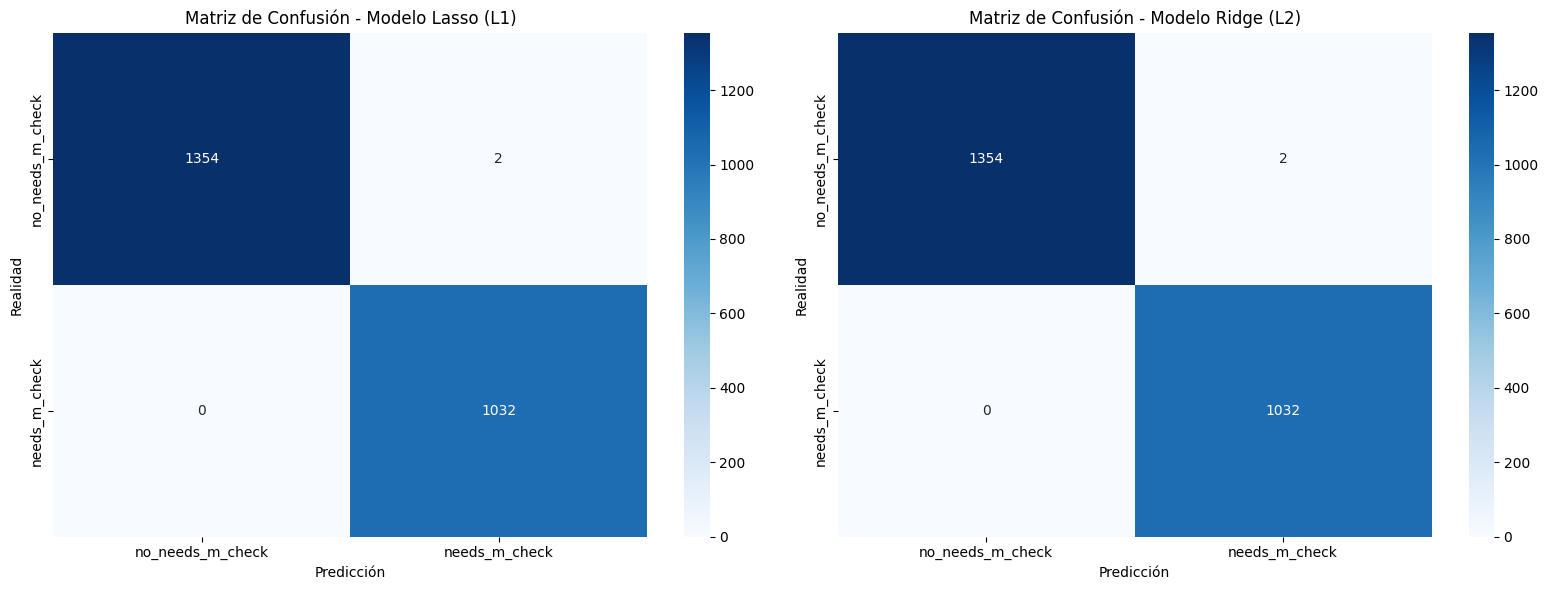

In [32]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos

print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [33]:
# Comparación resultados entre MODELO BASE y el modelo entrenado según LASSO y RIDGE

# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Base model con umbral modificado
accuracy_umbral = accuracy_score(y_test, predicciones_modificadas)
precision_umbral = precision_score(y_test, predicciones_modificadas)
recall_umbral = recall_score(y_test, predicciones_modificadas)
f1_umbral = f1_score(y_test, predicciones_modificadas)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla

metricas = {
    "R_LOG StandardScaler": ["Base", "Umbral 0.4","Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_umbral ,accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_umbral,precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_umbral, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_umbral, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_umbral, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  R_LOG StandardScaler  Accuracy  Precision  Recall  F1-Score   ROC-AUC
0                 Base  0.999162   0.998066     1.0  0.999032  0.999263
1           Umbral 0.4  0.997906   0.995178     1.0  0.997583  0.998156
2                Ridge  0.999162   0.998066     1.0  0.999032  0.999263
3                Lasso  0.999162   0.998066     1.0  0.999032  0.999263


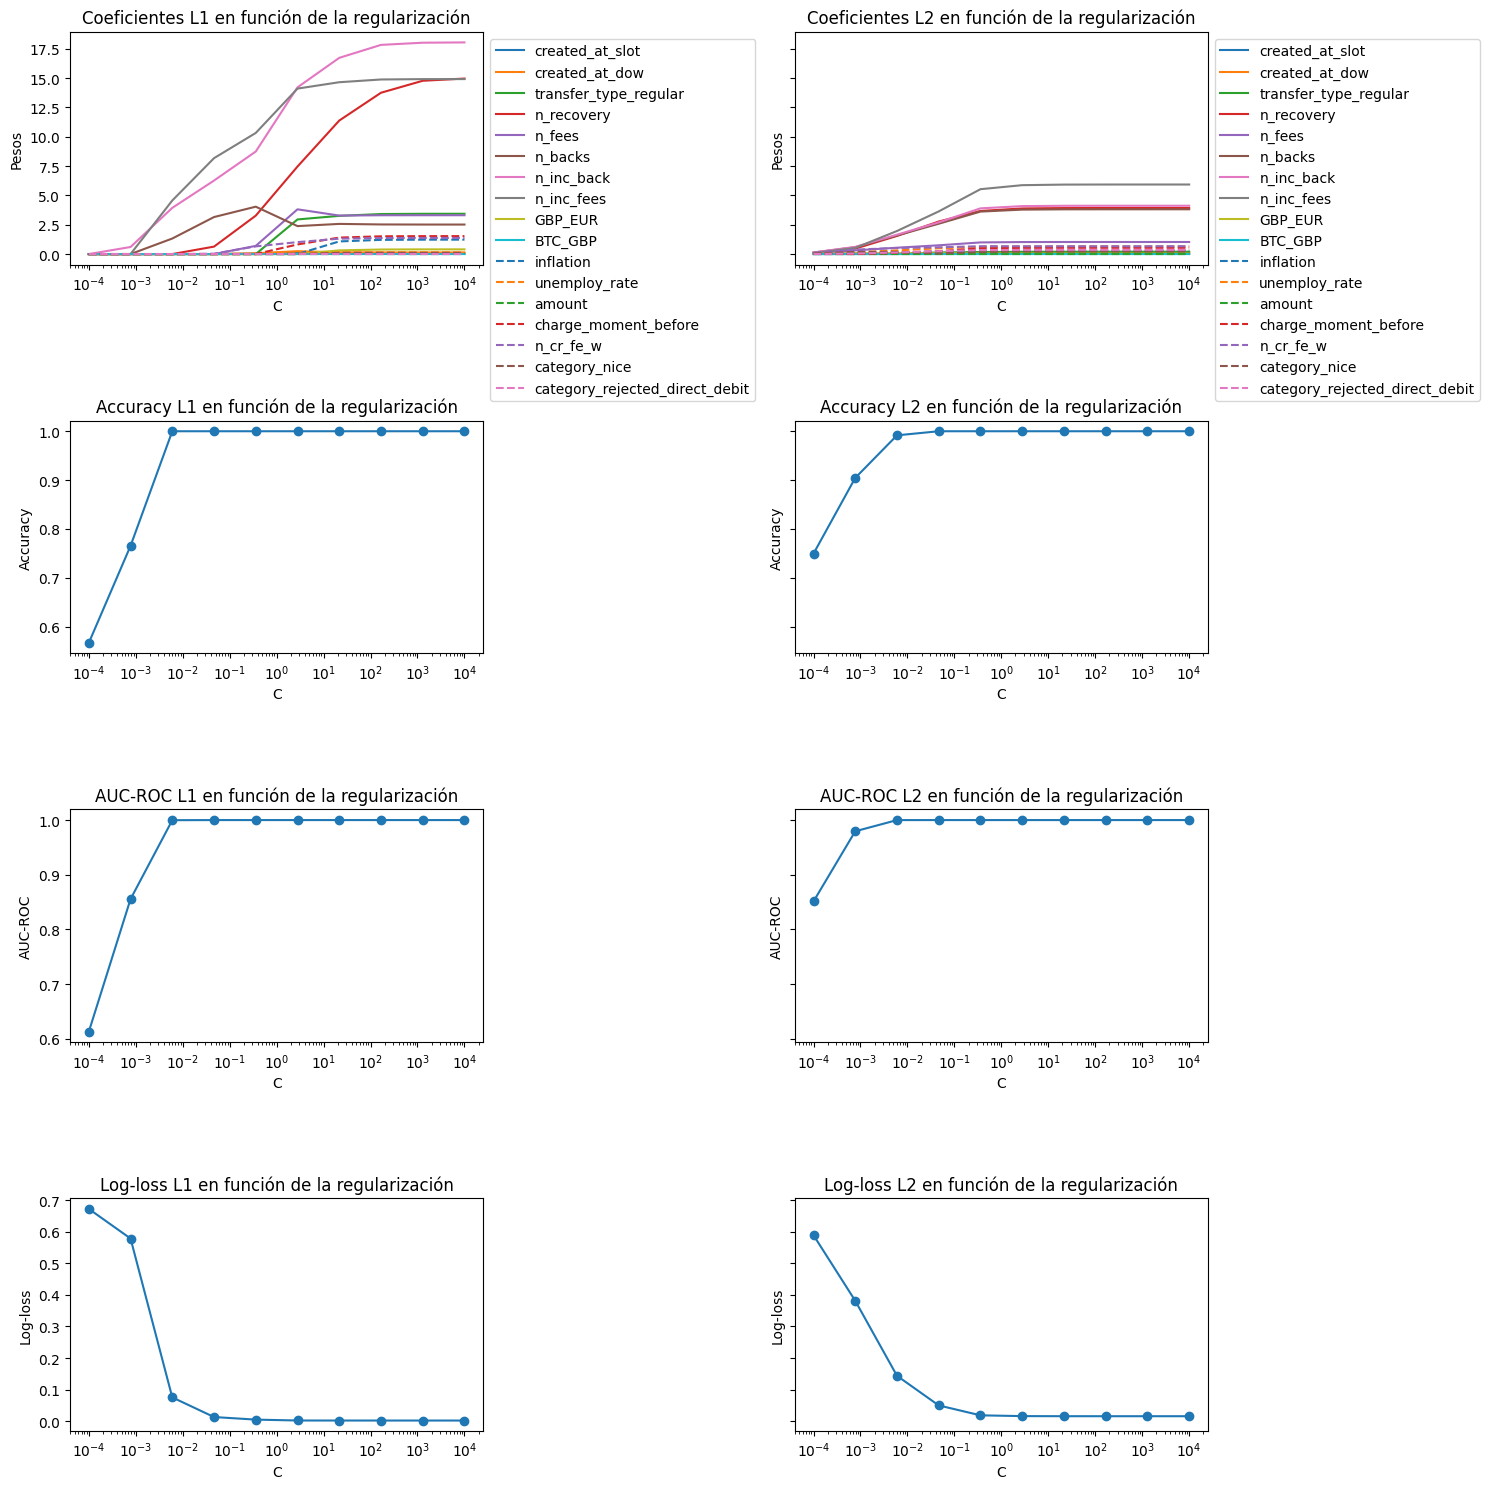

In [35]:
# Graficar el C (que es 1/alpha)

# Valores de C para probar (equivalente a 1/alpha en regresión logística)
C_values = np.logspace(-4, 4, 10)

# Inicialización de listas para almacenar resultados
coefs_logreg_l1 = []
coefs_logreg_l2 = []
accuracy_l1 = []
accuracy_l2 = []
auc_l1 = []
auc_l2 = []
logloss_l1 = []
logloss_l2 = []

# Modelos y evaluación
for C in C_values:
    # Penalización L1
    logreg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=42)
    logreg_l1.fit(X_train, y_train)
    coefs_logreg_l1.append(logreg_l1.coef_[0])  # Guardar coeficientes
    y_pred_prob_l1 = logreg_l1.predict_proba(X_test)[:, 1]  # Probabilidades para ROC y log-loss
    accuracy_l1.append(logreg_l1.score(X_test, y_pred_l1))
    auc_l1.append(roc_auc_score(y_test, y_pred_prob_l1))  # AUC-ROC
    logloss_l1.append(log_loss(y_test, y_pred_prob_l1))  # Log-loss

    # Penalización L2
    logreg_l2 = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=1000, random_state=42)
    logreg_l2.fit(X_train, y_train)
    coefs_logreg_l2.append(logreg_l2.coef_[0])  # Guardar coeficientes
    y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]
    accuracy_l2.append(logreg_l2.score(X_test, y_pred_l2))
    auc_l2.append(roc_auc_score(y_test, y_pred_prob_l2))  # AUC-ROC
    logloss_l2.append(log_loss(y_test, y_pred_prob_l2))  # Log-loss


# Configuración del gráfico
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='row')

# Definir los colores y estilos de línea
colors = plt.cm.tab10.colors  # Paleta de colores
line_styles = ['-', '--', '-.', ':']  # Diferentes tipos de línea

# Coeficientes L1
for i, coef in enumerate(np.abs(coefs_logreg_l1).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 0].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 0].set_xscale('log')
axs[0, 0].set_title('Coeficientes L1 en función de la regularización')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Pesos')
axs[0, 0].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,0].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

# Coeficientes L2
for i, coef in enumerate(np.abs(coefs_logreg_l2).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 1].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 1].set_xscale('log')
axs[0, 1].set_title('Coeficientes L2 en función de la regularización')
axs[0, 1].set_xlabel('C')
axs[0, 1].set_ylabel('Pesos')
axs[0, 1].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,1].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

#Graficar Accuracy para ver como varia un función de las C
# Accuracy L1
axs[1, 0].plot(C_values, accuracy_l1, marker='o')
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('Accuracy L1 en función de la regularización')
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('Accuracy')

# Accuracy L2
axs[1, 1].plot(C_values, accuracy_l2, marker='o')
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('Accuracy L2 en función de la regularización')
axs[1, 1].set_xlabel('C')
axs[1, 1].set_ylabel('Accuracy')

#Graficar AUC-ROC para ver como cambia rendimiento del modelo en términos de discriminación entre las clases postiva y negativa
# AUC-ROC L1
axs[2, 0].plot(C_values, auc_l1, marker='o')
axs[2, 0].set_xscale('log')
axs[2, 0].set_title('AUC-ROC L1 en función de la regularización')
axs[2, 0].set_xlabel('C')
axs[2, 0].set_ylabel('AUC-ROC')

# AUC-ROC L2
axs[2, 1].plot(C_values, auc_l2, marker='o')
axs[2, 1].set_xscale('log')
axs[2, 1].set_title('AUC-ROC L2 en función de la regularización')
axs[2, 1].set_xlabel('C')
axs[2, 1].set_ylabel('AUC-ROC')

# Graficar Log-loss para ver como cambia la calidad de las predicciones (mide la perdida del modelo,los errores q hace)
# Log-loss L1
axs[3, 0].plot(C_values, logloss_l1, marker='o')
axs[3, 0].set_xscale('log')
axs[3, 0].set_title('Log-loss L1 en función de la regularización')
axs[3, 0].set_xlabel('C')
axs[3, 0].set_ylabel('Log-loss')

# Log-loss L2
axs[3, 1].plot(C_values, logloss_l2, marker='o')
axs[3, 1].set_xscale('log')
axs[3, 1].set_title('Log-loss L2 en función de la regularización')
axs[3, 1].set_xlabel('C')
axs[3, 1].set_ylabel('Log-loss')

plt.tight_layout()
plt.show()


Total de muestras: 500
500


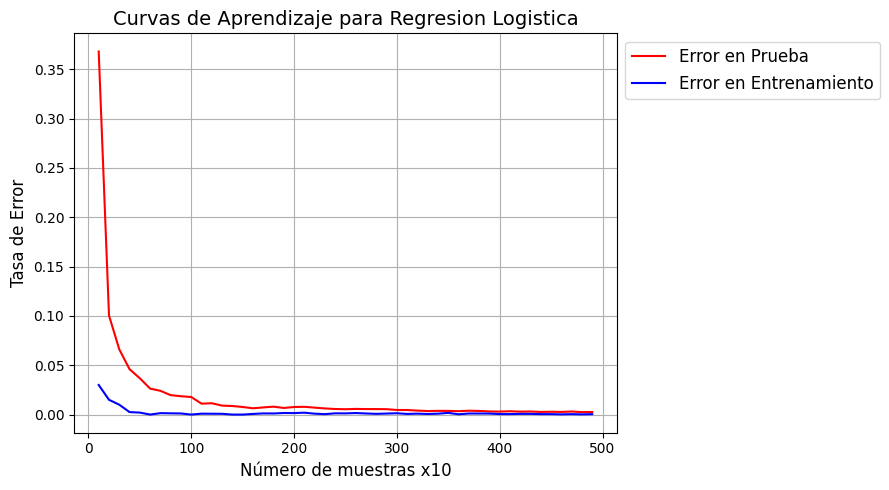

In [36]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()